<a href="https://colab.research.google.com/github/Mike030668/MIPT_magistratura/blob/main/NLP/DZ_2_text_classification_berta_hf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Задание

Для закрепления материала модуля предлагаем вам поучаствовать в учебном [Kaggle-соревновании](https://www.kaggle.com/competitions/unit-3-nlp-txt-classification/data).

Вам необходимо решить задачу классификации текстов, используя рекуррентные сети.
______

При выполнении проекта разрешается пользоваться любыми средствами для векторных представлений текстов, кроме трансформеров, и любыми вариантами рекуррентных сетей. Для достижения наилучшего результата уделите внимание подбору гиперапарметров как в плане архитектуры, так и в плане обучения модели.
______

Критерии самооценивания проекта:

- общее качество кода и следование PEP-8;
- использование рекуррентных сетей;
- итоговое значение метрики качества.

#PIP

In [ ]:
!pip install transformers -q
!pip install datasets -q
!pip install evaluate -q
!pip install accelerate -U
!pip install transformers[torch]
exit() #restart

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 53.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 102.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 81.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 5.3 MB/s eta 0:00:00


# Подключение к Kaggle

In [ ]:
api_token = {"username":"...","key":"..."}

import json

with open('/content/kaggle.json', 'w') as file:
  json.dump(api_token, file)

In [ ]:
# Загрузка датасета с Кеггла
!pip install kaggle -q
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!pip install --upgrade --force-reinstall --no-deps kaggle==1.5.12 -q
!kaggle --version

Kaggle API 1.5.12


# Загрузка данных соревнования

In [ ]:
!kaggle competitions download -c unit-3-nlp-txt-classification
!unzip '/content/unit-3-nlp-txt-classification.zip' -d'/content/data/'

unit-3-nlp-txt-classification.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  /content/unit-3-nlp-txt-classification.zip
replace /content/data/sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import os
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

os.listdir() # корневая папка

['.config',
 'data',
 'unit-3-nlp-txt-classification.zip',
 'kaggle.json',
 'sample_data']

## Читаем все в датафреймы.

In [ ]:
INPUT_PATH = '/content/data'  # папка с данными
# данные для обучения
main_ds = pd.read_csv(os.path.join(INPUT_PATH, 'train.csv'), index_col=0)
# тестовые данные
test_ds = pd.read_csv(os.path.join(INPUT_PATH, 'test.csv'), index_col=0)
# пример для загрузки ответов
sample_submission = pd.read_csv(os.path.join(INPUT_PATH, 'sample_submission.csv'))
# размер данных
main_ds.shape, test_ds.shape, sample_submission.shape

((41159, 2), (3798, 1), (3798, 2))

In [ ]:
# train dataset
main_ds.head()

,Text,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [ ]:
main_ds.sample(1).Text.tolist()[0]

'Mabrouq: A Regional COVID-19 Emergency Fund has been established, and Maldives has donated US $200K to the Fund. STO has reduced the prices of diesel and petrol.'

In [ ]:
# train dataset Sentiment.value_counts()
main_ds.Sentiment.value_counts()

Positive              11422
Negative               9917
Neutral                7711
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64

In [ ]:
# test dataset
main_ds.head()

,Text,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [ ]:
# sample_submission
print(sample_submission.Sentiment.value_counts())
print()
sample_submission.head()


Neutral    3798
Name: Sentiment, dtype: int64



,id,Sentiment
0,787bc85b-20d4-46d8-84a0-562a2527f684,Neutral
1,17e934cd-ba94-4d4f-9ac0-ead202abe241,Neutral
2,5914534b-2b0f-4de8-bb8a-e25587697e0d,Neutral
3,cdf06cfe-29ae-48ee-ac6d-be448103ba45,Neutral
4,aff63979-0256-4fb9-a2d9-86a3d3ca5470,Neutral


## Импорты и константы

In [ ]:
import time
import re
from tqdm import tqdm



In [ ]:
NUM_CLASSES = len(main_ds.Sentiment.value_counts().index)
print(f'NUM_CLASSES = {NUM_CLASSES}')


NUM_CLASSES = 5


## Чистка и предобработка

In [ ]:
# пропуски
main_ds.isna().sum()

Text         1
Sentiment    4
dtype: int64

Есть совсем немного (от 4 до 6) NaNов в 41159 строках. Проще от них избавиться.

In [ ]:
# удаляем
main_ds = main_ds.dropna()
main_ds.isna().sum()

Text         0
Sentiment    0
dtype: int64

## Есть ли баланс в данных?

Extremely Negative     5481
Extremely Positive     6624
Negative               9917
Neutral                7711
Positive              11422
Name: Sentiment, dtype: int64


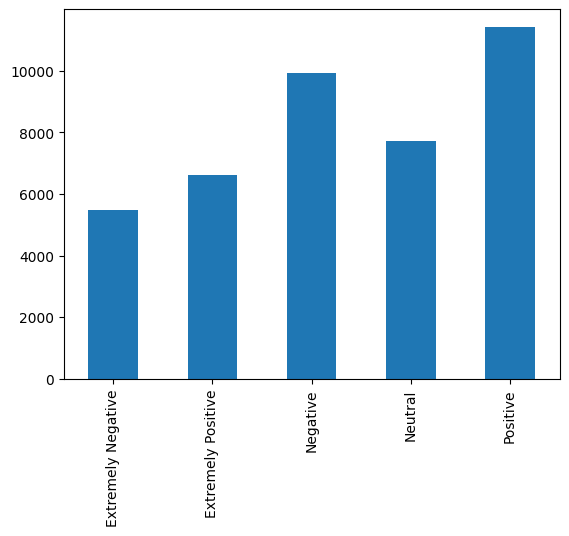

In [ ]:
# давайте посмотрим распределение оценок
import matplotlib.pyplot as plt
%matplotlib inline
# value_counts () - a command that allows you to calculate the number of unique values
vc = main_ds.Sentiment.value_counts()
vc = vc.sort_index()
print(vc)
vc.plot(kind='bar');

Самый частый класс больше самого редкого в два раза. Пока как есть пробуем.

На следующем этаме можно добавить аугментацию

Посмотрим на длину текстов.

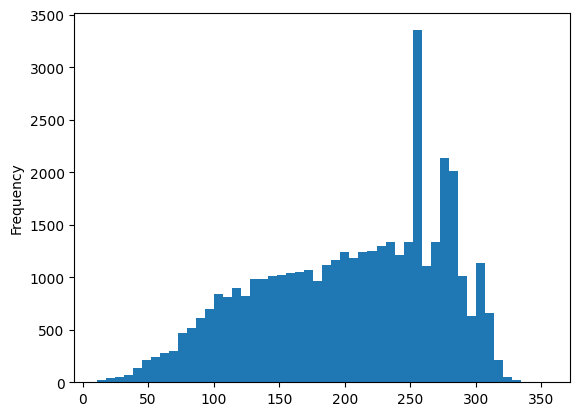

In [ ]:
lens = main_ds.Text.apply(lambda s: len(s))
lens.plot.hist(bins=50);

In [ ]:
lens.quantile(0.95), max(lens)

(300.0, 355)

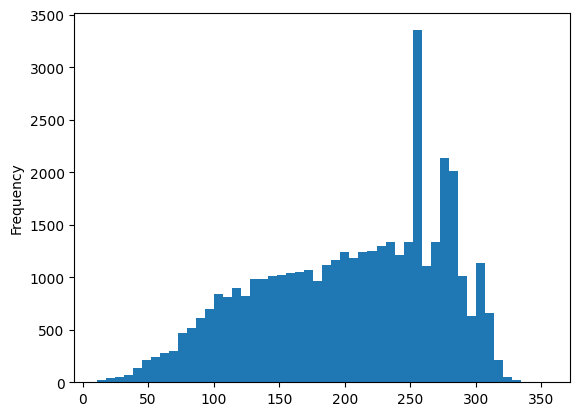

In [ ]:
lens = main_ds.Text.apply(lambda s: len(s))
lens.plot.hist(bins=50);

In [ ]:
lens.quantile(0.95), max(lens)

(300.0, 355)

# Sentences cleaning

Подберем то, что мы очищаем в данных

## abbreviaturs clearning

In [ ]:
# Thanks to https://www.kaggle.com/rftexas/text-only-kfold-bert
abbreviations = {
    "Â": "'",
    "$" : " dollar ",
    "€" : " euro ",
    "Â" : "",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk",
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart",
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet",
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously",
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired",
}

In [ ]:
def convert_abbrev(text):
    new_text = ''
    for word in text.split():
      if word.lower() in abbreviations.keys():
        new_text += ' ' + word[0] + abbreviations[word.lower()][1:]
      else:
        new_text += ' ' + word
    return ' '.join(new_text.split())

In [ ]:
#sentence = main_ds.sample().Text.values[0]
sentence = "So ygtr now weÂre NOT supposed to go to the grocery store??  Really? Did I miss this before? #TrumpPressBriefing #COVID2019"
print(sentence)
print()
sentence = convert_abbrev(sentence)
print(sentence)

So ygtr now weÂre NOT supposed to go to the grocery store??  Really? Did I miss this before? #TrumpPressBriefing #COVID2019

So you got that right now weÂre NOT supposed to go to the grocery store?? Really? Did I miss this before? #TrumpPressBriefing #COVID2019


## Phrases with apostrophes

Словосочетания с апострофами в английском лушче раскрыть.

In [ ]:
contraction_dict = {"ain't": "is not",
                    "aren't": "are not",
                    "can't": "can not",
                    "'cause": "because",
                    "could've": "could have",
                    "couldn't": "could not",
                    "didn't": "did not",
                    "doesn't": "does not",
                    "don't": "do not",
                    "hadn't": "had not",
                    "hasn't": "has not",
                    "haven't": "have not",
                    "he'd": "he would",
                    "he'll": "he will",
                    "he's": "he is",
                    "how'd": "how did",
                    "how'd'y": "how do you",
                    "how'll": "how will",
                    "how's": "how is",
                    "I'd": "I would",
                    "I'd've": "I would have",
                    "I'll": "I will",
                    "I'll've": "I will have",
                    "I'm": "I am",
                    "I've": "I have",
                    "i'd": "i would",
                    "i'd've": "i would have",
                    "i'll": "i will",
                    "i'll've": "i will have",
                    "i'm": "i am",
                    "i've": "i have",
                    "isn't": "is not",
                    "it'd": "it would",
                    "it'd've": "it would have",
                    "it'll": "it will",
                    "it'll've": "it will have",
                    "it's": "it is",
                    "let's": "let us",
                    "ma'am": "madam",
                    "mayn't": "may not",
                    "might've": "might have",
                    "mightn't": "might not",
                    "mightn't've": "might not have",
                    "must've": "must have",
                    "mustn't": "must not",
                    "mustn't've": "must not have",
                    "needn't": "need not",
                    "needn't've": "need not have",
                    "o'clock": "of the clock",
                    "oughtn't": "ought not",
                    "oughtn't've": "ought not have",
                    "shan't": "shall not",
                    "sha'n't": "shall not",
                    "shan't've": "shall not have",
                    "she'd": "she would",
                    "she'd've": "she would have",
                    "she'll": "she will",
                    "she'll've": "she will have",
                    "she's": "she is",
                    "should've": "should have",
                    "shouldn't": "should not",
                    "shouldn't've": "should not have",
                    "so've": "so have",
                    "so's": "so as",
                    "this's": "this is",
                    "that'd": "that would",
                    "that'd've": "that would have",
                    "that's": "that is",
                    "there'd": "there would",
                    "there'd've": "there would have",
                    "there's": "there is",
                    "here's": "here is",
                    "they'd": "they would",
                    "they'd've": "they would have",
                    "they'll": "they will",
                    "they'll've": "they will have",
                    "they're": "they are",
                    "they've": "they have",
                    "to've": "to have",
                    "wasn't": "was not",
                    "we'd": "we would",
                    "we'd've": "we would have",
                    "we'll": "we will",
                    "we'll've": "we will have",
                    "we're": "we are",
                    "we've": "we have",
                    "weren't": "were not",
                    "what'll": "what will",
                    "what'll've": "what will have",
                    "what're": "what are",
                    "what's": "what is",
                    "what've": "what have",
                    "when's": "when is",
                    "when've": "when have",
                    "where'd": "where did",
                    "where's": "where is",
                    "where've": "where have",
                    "who'll": "who will",
                    "who'll've": "who will have",
                    "who's": "who is",
                    "who've": "who have",
                    "why's": "why is",
                    "why've": "why have",
                    "will've": "will have",
                    "won't": "will not",
                    "won't've": "will not have",
                    "would've": "would have",
                    "wouldn't": "would not",
                    "wouldn't've": "would not have",
                    "y'all": "you all",
                    "y'all'd": "you all would",
                    "y'all'd've": "you all would have",
                    "y'all're": "you all are",
                    "y'all've": "you all have",
                    "you'd": "you would",
                    "you'd've": "you would have",
                    "you'll": "you will",
                    "you'll've": "you will have",
                    "you're": "you are",
                    "you've": "you have"}

In [ ]:
def convert_contractions(text):
    new_text = ''
    for word in text.split():
      if word.lower() in contraction_dict.keys():
        new_text += ' ' + word[0] + contraction_dict[word.lower()][1:]
      else:
        new_text += ' ' + word
    return ' '.join(new_text.split())

In [ ]:
sentence = "We're running as much product as we can, harvesting as many chickens as we can, (and) we are working Saturdays if we have the supply" #
print(sentence)
print()
print(convert_contractions(sentence))

We're running as much product as we can, harvesting as many chickens as we can, (and) we are working Saturdays if we have the supply

We are running as much product as we can, harvesting as many chickens as we can, (and) we are working Saturdays if we have the supply


##Convert Emojis

In [ ]:
!pip install demoji -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 1.0 MB/s eta 0:00:00


In [ ]:
import demoji

demoji.download_codes()

In [ ]:
#converting Emojis
def convert_emoji(text):
  new_text = ''
  for word in text.split():
    emj = demoji.findall_list(word)
    if len(emj):
      new_text+=' ' + ''.join((c +' ') for c in emj)
    else: new_text+=' ' +word
  return new_text

In [ ]:
sentence = main_ds.sample().Text.values[0] + "\U0001F600-\U0001F64F"
print(sentence)
print()
print(convert_emoji(sentence))





#corona #food #newbedfordma #newbedford #covid19 #coronavirus #quarantine #investments #insurance #dartmouthma #fairhavenma #fallriverma https://t.co/Ji3jPmbZB3😀-🙏

 How much are you spending to stock up for a 2 week quarantine? This graphic from @howmuch_net shows us what these costs could look like. #corona #food #newbedfordma #newbedford #covid19 #coronavirus #quarantine #investments #insurance #dartmouthma #fairhavenma #fallriverma grinning face folded hands 


## Remove special characters

In [ ]:
import string
from bs4 import BeautifulSoup
#Removing the html strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

#Removing punctuations
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

#Removing URL
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

#Removing the noisy text
def denoise_text(text):
    text = remove_URL(text)
    text = remove_between_square_brackets(text)
    text = remove_punct(text)
    return text

In [ ]:
sentence = main_ds.sample().Text.values[0]
print(sentence)
print()
print(denoise_text(sentence))







#StayHomeSaveLives







StayHomeSaveLives


In [ ]:
def remove_special_characters(text, remove_digits=True):
    text = re.sub('http://\S+|https://\S+|www.\S+|\n|#|\r', '', text)
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text.strip()

In [ ]:
print(sentence)
print()
remove_special_characters(sentence)







#StayHomeSaveLives



'I go back to work on Wednesday And Im terrified Working retail in a grocery store were on the front line And even though my job is being carefulThe humans are notMy family isnt safeStayHomeSaveLives'

In [ ]:
def convert2several_words(text):
  return "".join((" " + w if (w.isupper() and i) else w) for i, w in enumerate(text))#.strip().split() #' '.join(w for w in re.findall('[A-Z][^A-Z]*', text))

In [ ]:
def convert2several_words(text):
  new_text = ''
  for word in text.split():
    if not word.isupper():
      word = "".join((" " + w if (w.isupper() and i) else w) for i, w in enumerate(word))
      new_text+= " " + word
    else:
      new_text+=' '+word
  return ' '.join(new_text.split())

In [ ]:
sentence = 'With apologies this is that Talkwalker post consumer trends for content in coronavirus times DigitalMarketing'
convert2several_words(sentence)

'With apologies this is that Talkwalker post consumer trends for content in coronavirus times Digital Marketing'

## Mix clearing

In [ ]:
#Collect all functions
def clean_text(text):
    text = remove_URL(text)
    text = convert_emoji(text)
    text = convert_abbrev(text)
    text = convert_contractions(text)
    text = convert2several_words(text)
    text = denoise_text(text)
    ext = remove_special_characters(text)
    #text = remove_stopwords(text)
    return ' '.join(text.split())

In [ ]:
sentence = main_ds.sample().Text.values[0]
print(sentence)
print()
print(clean_text(sentence))

Malik Supermarket apologises for 'disgusting profiteering' amid #coronavirus pandemic https://t.co/4ICiFtK5ke

Malik Supermarket apologises for disgusting profiteering amid coronavirus pandemic


In [ ]:
%timeit
main_ds['Text_clean'] = main_ds['Text'].apply(clean_text)
test_ds['Text_clean'] = test_ds['Text'].apply(clean_text)
main_ds.head()

,Text,Sentiment,Text_clean
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,Me Nyrbie Phil Gahan Chrisitv and and
1,advice Talk to your neighbours family to excha...,Positive,advice Talk to your neighbours family to excha...
2,Coronavirus Australia: Woolworths to give elde...,Positive,Coronavirus Australia Woolworths to give elder...
3,My food stock is not the only one which is emp...,Positive,My food stock is not the only one which is emp...
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative,Me ready to go at supermarket during the COVID...


In [ ]:
main_ds.sample(10)

,Text,Sentiment,Text_clean
18541,"Amid Covid-19 outbreak, local shopkeepers star...",Positive,Amid Covid19 outbreak local shopkeepers starte...
15692,Remember everyone keep your social distance at...,Extremely Positive,Remember everyone keep your social distance at...
14991,@amateuradam @PenguinUKBooks @panmacmillan @Ha...,Extremely Positive,amateuradam Penguin U K Books panmacmillan Hac...
26269,Good news Grants First Approval of Convalescen...,Extremely Positive,Good news Grants First Approval of Convalescen...
35587,@piersmorgan @susannareid100 Question: Are all...,Negative,piersmorgan susannareid100 Question Are all ne...
22988,@amazon how is this possible? And donÂt say t...,Positive,amazon how is this possible And don Ât say th...
22922,Impulse buying is on the rise to optimize for ...,Positive,Impulse buying is on the rise to optimize for ...
1084,Imagining the first hour of grocery store hour...,Neutral,Imagining the first hour of grocery store hour...
4934,"After we've recovered from the #coronavirus, I...",Extremely Positive,After we have recovered from the coronavirus I...
34654,Just had a text that reads: \r\r\n\r\r\nCONGR...,Extremely Positive,Just had a text that reads CONGRATULATIONS YOU...


# Look again

In [ ]:
def length(text):
    '''a function which returns the length of text'''
    return len(text)

Сьлвари для первода из имени класса в номер класса и обратно

In [ ]:
dict_lbl_to_sent = {k: v for k, v in enumerate(main_ds['Sentiment'].unique())}
dict_sent_to_lbl = {v: k for k, v in dict_lbl_to_sent.items()}
print(f'Encoded sentiment values: {dict_sent_to_lbl}')

Encoded sentiment values: {'Neutral': 0, 'Positive': 1, 'Extremely Negative': 2, 'Negative': 3, 'Extremely Positive': 4}


Добавим номера классов

In [ ]:
main_ds['Label'] = main_ds['Sentiment'].apply(lambda x: dict_sent_to_lbl[x])

Добавим длину текстов

In [ ]:
main_ds['length_text_clean'] = main_ds['Text_clean'].apply(length)
test_ds['length_text_clean'] = test_ds['Text_clean'].apply(length)

## Number of characters in text

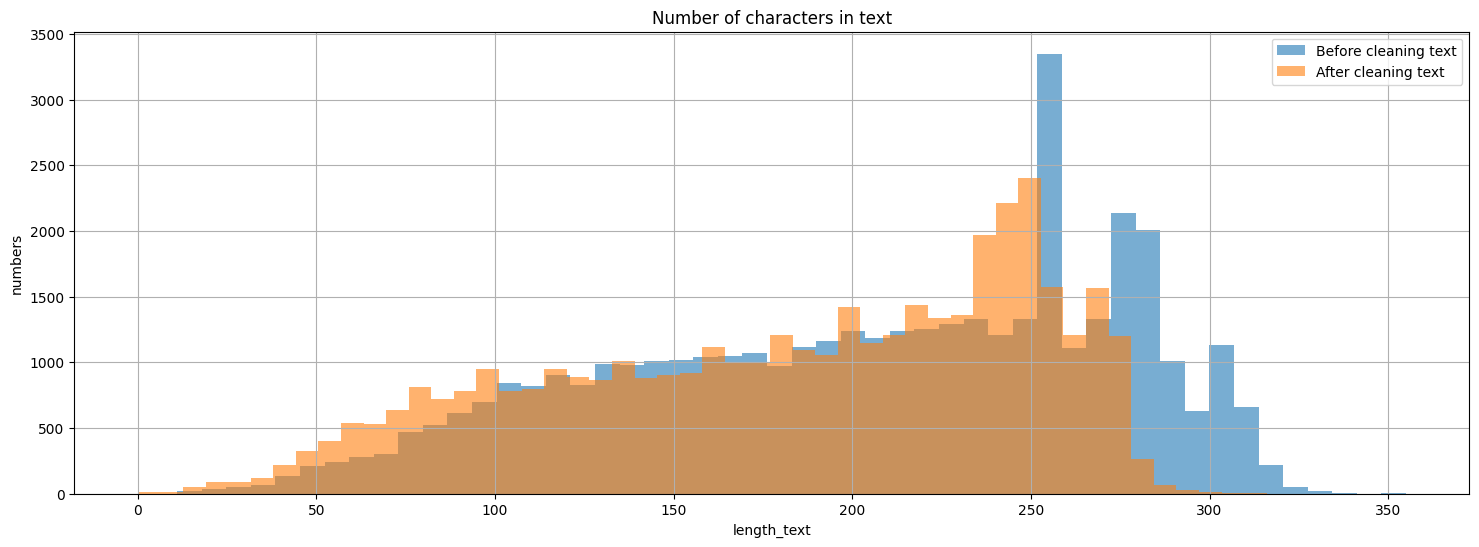

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
bins = 50
plt.hist(main_ds.Text.apply(length), alpha = 0.6, bins=bins, label='Before cleaning text')
plt.hist(main_ds['length_text_clean'], alpha = 0.6, bins=bins, label='After cleaning text')
plt.xlabel('length_text')
plt.ylabel('numbers')
plt.title('Number of characters in text')
plt.legend(loc='upper right')
plt.grid()
plt.show()

## Number of words in a text

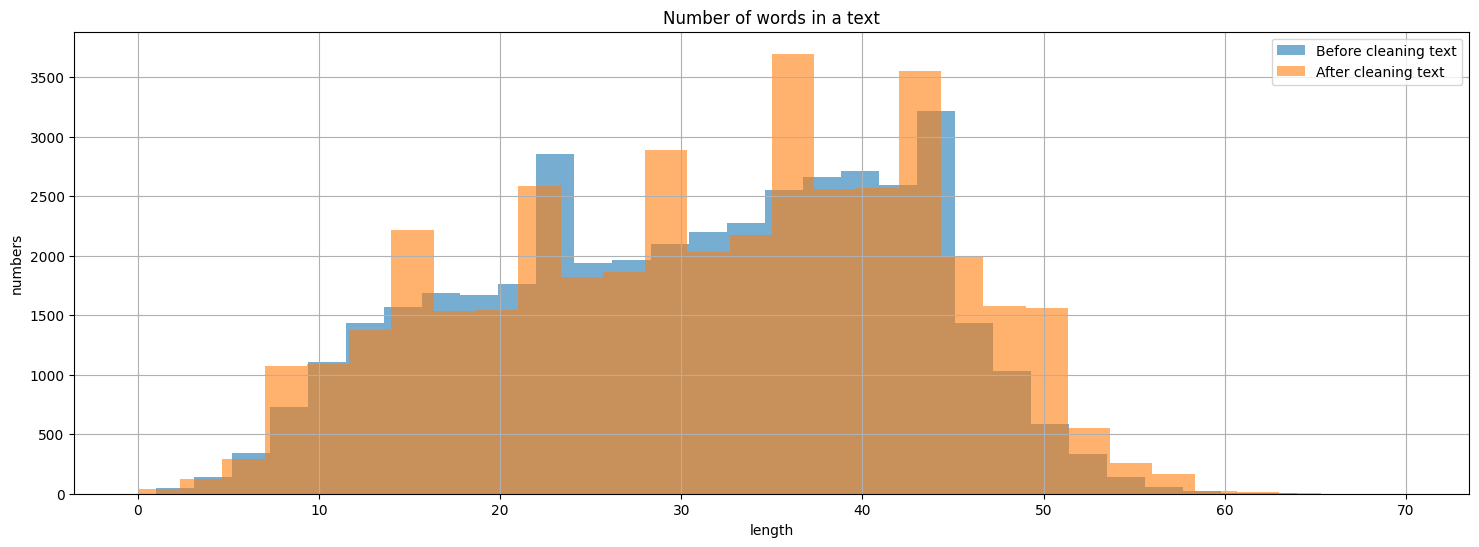

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
bins = 30
text_len=main_ds['Text'].str.split().map(lambda x: len(x))
text_len_clean=main_ds['Text_clean'].str.split().map(lambda x: len(x))
plt.hist(text_len, alpha = 0.6, bins=bins, label='Before cleaning text')
plt.hist(text_len_clean, alpha = 0.6, bins=bins, label='After cleaning text')
plt.xlabel('length')
plt.ylabel('numbers')
plt.title('Number of words in a text')
plt.legend(loc='upper right')
plt.grid()
plt.show()

## Removing blank lines


In [ ]:
main_ds[main_ds.length_text_clean == 0]

,Text,Sentiment,Text_clean,Label,length_text_clean
583,#????_???_?????? ???? ???????..? ?? ?????? ?? ...,Neutral,,0,0
5214,???? ???????? ??????????? - ???????? ?????????...,Neutral,,0,0
13843,? ???? ????? ???? ??? ?????? ??? ???\r\r\n\r\r...,Neutral,,0,0
14840,???? ??????? ??????? ????? ??? ?????? ??????? ...,Neutral,,0,0
16920,???? ??????? ??????? ???? ????? ???? ???? ????...,Neutral,,0,0
16924,????? ?\r\r\n\r\r\n???? ??? ???? ??? ?????????...,Neutral,,0,0
18437,????? ?? ??????? ?? ??????? ???? ???? ????????...,Neutral,,0,0
29888,???? ????? \r\r\n????? ??? ? ?? ?? ??\r\r\n\r\...,Neutral,,0,0
32455,?? ?? ??? ??? ??? ????! https://t.co/2VAcVOugv1,Neutral,,0,0
36781,??? ???? ????? ?? ?????? ???? ????? ? ???? ???...,Neutral,,0,0


In [ ]:
main_ds = main_ds.drop(main_ds[main_ds.length_text_clean == 0].index)

В тестовом стоит также почистить перед предиктом, а этим поставить - `Neutral`

In [ ]:
main_ds[main_ds.length_text_clean == 4]

,Text,Sentiment,Text_clean,Label,length_text_clean


Extremely Negative     5481
Extremely Positive     6624
Negative               9917
Neutral                7701
Positive              11422
Name: Sentiment, dtype: int64


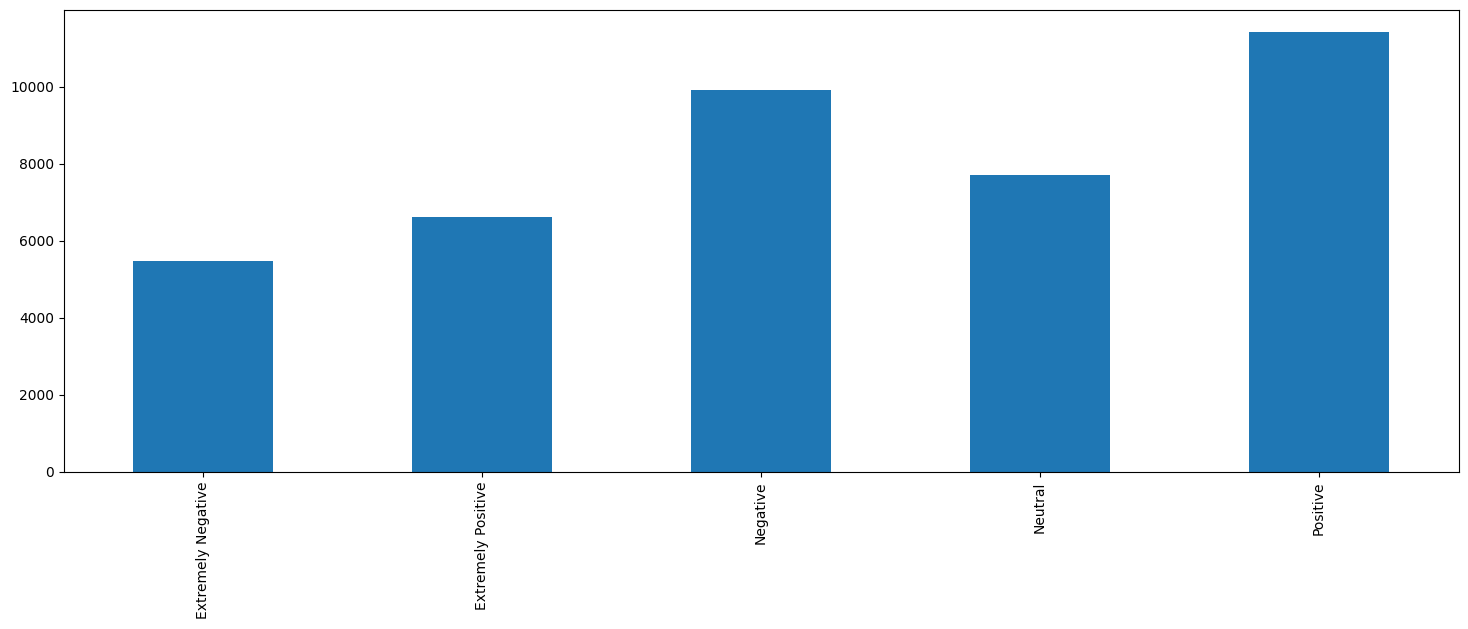

In [ ]:
# value_counts () - a command that allows you to calculate the number of unique values
vc = main_ds.Sentiment.value_counts()
vc = vc.sort_index()
print(vc)
vc.plot(kind='bar');

In [ ]:
main_ds

,Text,Sentiment,Text_clean,Label,length_text_clean
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,Me Nyrbie Phil Gahan Chrisitv and and,0,37
1,advice Talk to your neighbours family to excha...,Positive,advice Talk to your neighbours family to excha...,1,237
2,Coronavirus Australia: Woolworths to give elde...,Positive,Coronavirus Australia Woolworths to give elder...,1,104
3,My food stock is not the only one which is emp...,Positive,My food stock is not the only one which is emp...,1,259
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative,Me ready to go at supermarket during the COVID...,2,265
...,...,...,...,...,...
41152,Airline pilots offering to stock supermarket s...,Neutral,Airline pilots offering to stock supermarket s...,0,75
41153,Response to complaint not provided citing COVI...,Extremely Negative,Response to complaint not provided citing COVI...,2,133
41154,You know itÂs getting tough when @KameronWild...,Positive,You know it Âs getting tough when Kameron Wil...,1,130
41155,Is it wrong that the smell of hand sanitizer i...,Neutral,Is it wrong that the smell of hand sanitizer i...,0,102


#  Train_test_split

In [ ]:
new_df = main_ds[['Text_clean', 'Label']]

###  train_test_split

In [ ]:
from sklearn.model_selection import train_test_split
SEED = 200
train_size = 0.8



train_data, valid_data = train_test_split(new_df,
                                          stratify= new_df.Label,
                                          test_size=0.2,
                                          random_state=SEED)

### Check Max_Len

Долго, уже вычисленно , закомитил

In [ ]:
# Concatenate train data and test data
#all_texts = np.concatenate([main_ds.Text_clean.values, test_ds.Text_clean.values])

# Encode our concatenated data
#encoded_texts = [tokenizer.encode(sent, add_special_tokens=True) for sent in all_texts]

# Find the maximum length
#max_len = max([len(sent) for sent in encoded_texts])
#print('Max length: ', max_len)

# Dataset

In [ ]:
from datasets import Dataset, DatasetDict
import datasets
from transformers import Trainer, TrainingArguments, set_seed

from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import DataCollatorWithPadding

from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import BertTokenizer, BertForSequenceClassification

In [ ]:
test_ds['Label'] = 0
dataset = DatasetDict({
    "train": Dataset.from_pandas(train_data.reset_index(drop = True)),
    "valid": Dataset.from_pandas(valid_data.reset_index(drop = True)),
    'test': Dataset.from_pandas(test_ds[['Text_clean', 'Label']].reset_index(drop = True))
    })
dataset

DatasetDict({
    train: Dataset({
        features: ['Text_clean', 'Label'],
        num_rows: 32916
    })
    valid: Dataset({
        features: ['Text_clean', 'Label'],
        num_rows: 8229
    })
    test: Dataset({
        features: ['Text_clean', 'Label'],
        num_rows: 3798
    })
})

In [ ]:
import torch

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def preprocess_data(examples):

    encoding = tokenizer(examples['Text_clean'])
    return encoding

checkpoint = f"bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

#checkpoint = "yiyanghkust/finbert-esg-9-categories"
#tokenizer = BertTokenizer.from_pretrained(checkpoint)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding = True)

encoded_dataset = dataset.map(preprocess_data, batched = True)
encoded_dataset = encoded_dataset.remove_columns(['Text_clean'])
encoded_dataset = encoded_dataset.rename_column("Label", "labels")
encoded_dataset.set_format("torch")
encoded_dataset

Map:   0%|          | 0/32916 [00:00<?, ? examples/s]

Map:   0%|          | 0/8229 [00:00<?, ? examples/s]

Map:   0%|          | 0/3798 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 32916
    })
    valid: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 8229
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3798
    })
})

# Small train to find best way

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import evaluate
from transformers import EvalPrediction

In [ ]:
MAX_LEN = 123
N_EPOCHS = 3
LR_VALUES = (1e-5, 3e-5)
DECAY_VALUES = (3e-4, 0.2)
BATCH_SIZES = (12, 24)

In [ ]:
ACCURACY = evaluate.load("accuracy")
MCC = evaluate.load("matthews_correlation")

def compute_metrics(p: EvalPrediction):
    preds = p.predictions
    preds = np.argmax(preds, axis=1)

    acc_result = ACCURACY.compute(predictions=preds, references=p.label_ids)
    mcc_result = MCC.compute(predictions=preds, references=p.label_ids)
    result = {"accuracy": acc_result["accuracy"], "mcc": mcc_result["matthews_correlation"]}

    return result

In [ ]:
main_dir = '/content/drive/Othercomputers/My_comp/Documents/МФТИ - Наука о данных/NLP_course/DZ/Text_classification/'

In [ ]:
metrics = pd.DataFrame()

for i, learning_rate in enumerate(LR_VALUES):
    for j, weight_decay in enumerate(DECAY_VALUES):
        for k, batch_size in enumerate(BATCH_SIZES):

              model = AutoModelForSequenceClassification.from_pretrained(checkpoint,
                                                                          num_labels = NUM_CLASSES)


              print(f'Log: training for l_r:{learning_rate}, w_d:{weight_decay}, batch_size:{batch_size}...')
              training_args = TrainingArguments(
                  output_dir= main_dir + "Berta_HF",
                  overwrite_output_dir=True,
                  evaluation_strategy="epoch",
                  per_device_train_batch_size=batch_size,
                  per_device_eval_batch_size=batch_size,
                  learning_rate=learning_rate,
                  weight_decay=weight_decay,
                  num_train_epochs=N_EPOCHS,
                  warmup_ratio=0.1,
                  optim="adamw_torch",
                  save_strategy="no",
                  save_total_limit=1,
                  group_by_length=True,
                  report_to="none"

              )

              trainer = Trainer(
                  model=model,
                  args=training_args,
                  train_dataset=encoded_dataset['train'],
                  eval_dataset=encoded_dataset['valid'],
                  compute_metrics=compute_metrics,
                  tokenizer=tokenizer,
                  data_collator=data_collator,
              )

              train_result = trainer.train()
              print("train", train_result.metrics)


              valid_predictions = trainer.predict(test_dataset=encoded_dataset['valid'])
              print("valid", valid_predictions.metrics)

              metrics = pd.concat([metrics, pd.DataFrame([{'learn_rate': learning_rate,
                          'weight_decay': weight_decay,
                          'batch_size': batch_size,
                          'accuracy': valid_predictions.metrics["test_accuracy"],
                          'mcc': valid_predictions.metrics["test_mcc"]


              }])], ignore_index=True)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Log: training for l_r:1e-05, w_d:0.0003, batch_size:12...


Epoch,Training Loss,Validation Loss,Accuracy,Mcc
1,0.802100,0.729652,0.723174,0.646683
2,0.600000,0.645128,0.768259,0.707098
3,0.476500,0.634588,0.786244,0.729538


train {'train_runtime': 1317.9655, 'train_samples_per_second': 74.925, 'train_steps_per_second': 6.244, 'total_flos': 2038020629054184.0, 'train_loss': 0.7339707598359982, 'epoch': 3.0}


valid {'test_loss': 0.6345878839492798, 'test_accuracy': 0.7862437720257626, 'test_mcc': 0.7295375117081594, 'test_runtime': 35.7436, 'test_samples_per_second': 230.223, 'test_steps_per_second': 19.192}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Log: training for l_r:1e-05, w_d:0.0003, batch_size:24...


Epoch,Training Loss,Validation Loss,Accuracy,Mcc
1,1.022800,0.781375,0.695710,0.613073
2,0.661000,0.695712,0.738607,0.668185
3,0.543400,0.653154,0.763884,0.700481


train {'train_runtime': 1018.1729, 'train_samples_per_second': 96.985, 'train_steps_per_second': 4.043, 'total_flos': 2045556497103192.0, 'train_loss': 0.7903597000388988, 'epoch': 3.0}


valid {'test_loss': 0.6531540155410767, 'test_accuracy': 0.7638838254952, 'test_mcc': 0.7004811628845247, 'test_runtime': 32.7328, 'test_samples_per_second': 251.399, 'test_steps_per_second': 10.479}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Log: training for l_r:1e-05, w_d:0.2, batch_size:12...


Epoch,Training Loss,Validation Loss,Accuracy,Mcc
1,0.781800,0.717405,0.729129,0.654439
2,0.588600,0.636990,0.778223,0.718416
3,0.461200,0.620321,0.790376,0.734069


train {'train_runtime': 1276.7826, 'train_samples_per_second': 77.341, 'train_steps_per_second': 6.445, 'total_flos': 2038020629054184.0, 'train_loss': 0.7124717694786777, 'epoch': 3.0}


valid {'test_loss': 0.6203208565711975, 'test_accuracy': 0.7903755012759752, 'test_mcc': 0.7340693829654843, 'test_runtime': 33.5034, 'test_samples_per_second': 245.617, 'test_steps_per_second': 20.476}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Log: training for l_r:1e-05, w_d:0.2, batch_size:24...


Epoch,Training Loss,Validation Loss,Accuracy,Mcc
1,1.021700,0.780994,0.695224,0.612428
2,0.661700,0.697206,0.739336,0.669123
3,0.544400,0.653125,0.763519,0.700018


train {'train_runtime': 1010.7262, 'train_samples_per_second': 97.7, 'train_steps_per_second': 4.072, 'total_flos': 2045556497103192.0, 'train_loss': 0.7905310833766926, 'epoch': 3.0}


valid {'test_loss': 0.6531254649162292, 'test_accuracy': 0.7635192611495929, 'test_mcc': 0.7000181598784712, 'test_runtime': 32.6293, 'test_samples_per_second': 252.196, 'test_steps_per_second': 10.512}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Log: training for l_r:3e-05, w_d:0.0003, batch_size:12...


Epoch,Training Loss,Validation Loss,Accuracy,Mcc
1,0.687500,0.623055,0.766436,0.703579
2,0.468900,0.580825,0.808847,0.757479
3,0.295700,0.598837,0.833637,0.788866


train {'train_runtime': 1262.6373, 'train_samples_per_second': 78.208, 'train_steps_per_second': 6.517, 'total_flos': 2038020629054184.0, 'train_loss': 0.5742251606754754, 'epoch': 3.0}


valid {'test_loss': 0.5988370180130005, 'test_accuracy': 0.8336371369546725, 'test_mcc': 0.7888655058704113, 'test_runtime': 33.6528, 'test_samples_per_second': 244.527, 'test_steps_per_second': 20.385}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Log: training for l_r:3e-05, w_d:0.0003, batch_size:24...


Epoch,Training Loss,Validation Loss,Accuracy,Mcc
1,0.822500,0.641720,0.767408,0.703843
2,0.474800,0.553094,0.804472,0.751864
3,0.311000,0.540430,0.830356,0.784649


train {'train_runtime': 1008.2648, 'train_samples_per_second': 97.939, 'train_steps_per_second': 4.082, 'total_flos': 2045556497103192.0, 'train_loss': 0.5973513865494056, 'epoch': 3.0}


valid {'test_loss': 0.540429949760437, 'test_accuracy': 0.8303560578442095, 'test_mcc': 0.7846488161781733, 'test_runtime': 32.7701, 'test_samples_per_second': 251.113, 'test_steps_per_second': 10.467}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Log: training for l_r:3e-05, w_d:0.2, batch_size:12...


Epoch,Training Loss,Validation Loss,Accuracy,Mcc
1,0.681700,0.627473,0.766679,0.703930
2,0.464600,0.551292,0.814315,0.763931
3,0.296900,0.581216,0.837647,0.793871


train {'train_runtime': 1265.1861, 'train_samples_per_second': 78.05, 'train_steps_per_second': 6.504, 'total_flos': 2038020629054184.0, 'train_loss': 0.5710743143747117, 'epoch': 3.0}


valid {'test_loss': 0.5812162756919861, 'test_accuracy': 0.8376473447563495, 'test_mcc': 0.7938714285532708, 'test_runtime': 33.429, 'test_samples_per_second': 246.164, 'test_steps_per_second': 20.521}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Log: training for l_r:3e-05, w_d:0.2, batch_size:24...


Epoch,Training Loss,Validation Loss,Accuracy,Mcc
1,0.826500,0.637176,0.762547,0.697930
2,0.478100,0.551726,0.806416,0.754224
3,0.312900,0.537212,0.829384,0.783378


train {'train_runtime': 1014.1965, 'train_samples_per_second': 97.366, 'train_steps_per_second': 4.058, 'total_flos': 2045556497103192.0, 'train_loss': 0.599123494154742, 'epoch': 3.0}


valid {'test_loss': 0.537211537361145, 'test_accuracy': 0.8293838862559242, 'test_mcc': 0.7833782083645163, 'test_runtime': 32.7244, 'test_samples_per_second': 251.464, 'test_steps_per_second': 10.481}


In [ ]:
metrics.sort_values(by = 'mcc', ascending = False)

,learn_rate,weight_decay,batch_size,accuracy,mcc
6,0.00003,0.2000,12,0.837647,0.793871
4,0.00003,0.0003,12,0.833637,0.788866
5,0.00003,0.0003,24,0.830356,0.784649
7,0.00003,0.2000,24,0.829384,0.783378
2,0.00001,0.2000,12,0.790376,0.734069
0,0.00001,0.0003,12,0.786244,0.729538
1,0.00001,0.0003,24,0.763884,0.700481
3,0.00001,0.2000,24,0.763519,0.700018


# Train

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint,
#model = BertForSequenceClassification.from_pretrained(checkpoint,
                                                      ignore_mismatched_sizes=True,
                                                      num_labels = NUM_CLASSES)

training_args = TrainingArguments(
    output_dir=main_dir + "Berta_HF",
    overwrite_output_dir=True,
    evaluation_strategy="epoch",
    per_device_train_batch_size=12,
    per_device_eval_batch_size=12,
    learning_rate=0.00005	,
    weight_decay=0.2,
    num_train_epochs=3,
    warmup_ratio=0.1,
    optim="adamw_torch",
    save_strategy="no",
    save_total_limit=1,
    group_by_length=True,
    report_to="none"

)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset['train'],
    eval_dataset=encoded_dataset['valid'],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,Mcc
1,0.680500,0.735039,0.729979,0.660737
2,0.466700,0.539851,0.820634,0.771642
3,0.272800,0.605635,0.833394,0.788679


TrainOutput(global_step=8229, training_loss=0.5581101600534789, metrics={'train_runtime': 1148.6252, 'train_samples_per_second': 85.971, 'train_steps_per_second': 7.164, 'total_flos': 2038020629054184.0, 'train_loss': 0.5581101600534789, 'epoch': 3.0})

# Plot_confusion_matrix

In [ ]:
def confusion_matrix(y_true, y_pred, labels=None, normalize=None,
                     cmap="Blues", encoded_labels=True,
                     plot=True, verbose = False):
    """
    Args:
        y_true (ndarray)
        y_pred (ndarray)
        labels (list)
        normalise (str) : {'all', None}
        cmap (maplotlib.pyplot.cmap)
        encoded_labels (bool): Need to be False if labels are not one hot encoded
        plot (bool): If False, plot will not appear for confusion matrix

    Return:
        conf_mat (tuple): TN, FP, FN, TP
    """

    import seaborn as sns
    from sklearn.metrics import confusion_matrix

    if normalize not in ('all', None):
        raise ValueError("normalize must be one of {'all', None}")

    conf_labels = None if encoded_labels else labels
    fmt = 'g' if normalize == None else '.2%'

    conf_mat = confusion_matrix(y_true, y_pred, normalize=normalize, labels=conf_labels)

    if plot:
        plt.figure(figsize = (10,10))
        ax = sns.heatmap(conf_mat, cmap=cmap,
                         square=True, cbar=False,
                         annot=True, fmt=fmt,
                         annot_kws={'fontsize': 15,
                                    'fontweight': 'bold',
                                    'fontfamily': 'serif',
                                    }
                         )
        ax.set_title("Confusion Matrix", fontsize=18)
        ax.set_xlabel("Predicted", fontsize=11, color = "red")
        ax.set_ylabel("Actual", fontsize=11, color = "red")
        if labels != None:
            ax.set_yticklabels(labels,  fontsize=12)
            ax.set_xticklabels(labels,  fontsize=12)
    if verbose: return conf_mat

In [ ]:
predictions = trainer.predict(test_dataset=encoded_dataset['valid'])
pred_lbls = np.argmax(predictions.predictions, axis = 1)

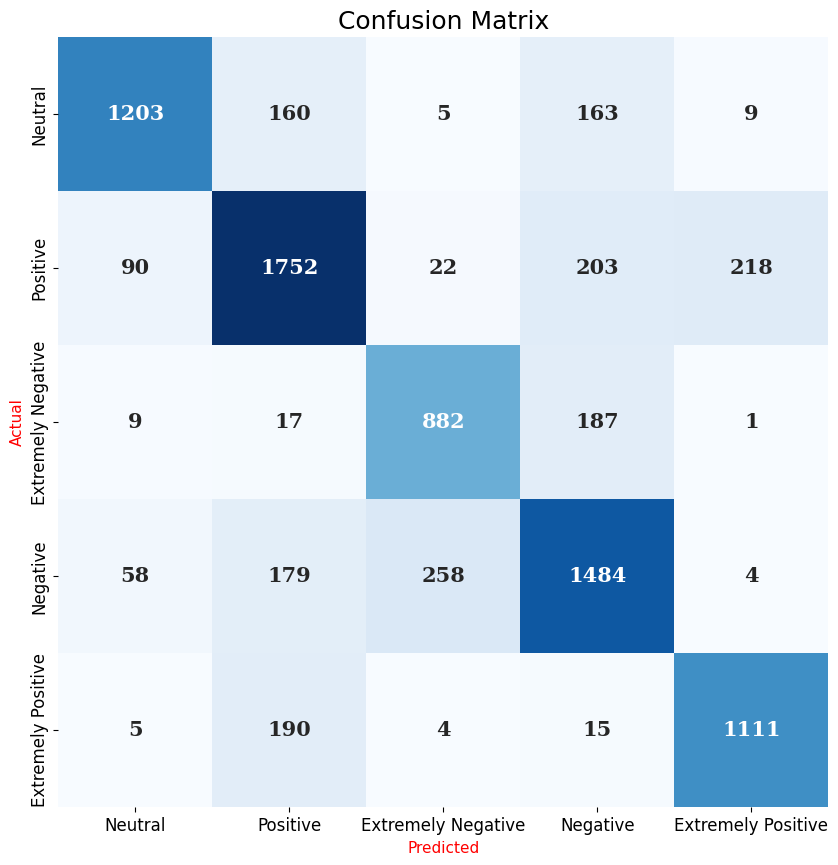

In [ ]:
y_val_lbls = encoded_dataset['valid'][:]['labels'].numpy()
confusion_matrix(y_val_lbls, pred_lbls, labels=dict_sent_to_lbl.keys()) #, normalize='all')

# Predict test

In [ ]:
test_dataset = encoded_dataset['test'].remove_columns(['labels'])
predictions = trainer.predict(test_dataset=test_dataset)
preds = []
for log in predictions.predictions:
    cls = np.argmax(log)
    preds.append(dict_lbl_to_sent[cls] )

test_ds['Sentiment'] = preds

In [ ]:
sample_submission.Sentiment = test_ds['Sentiment'].values
sample_submission.head()

,id,Sentiment
0,787bc85b-20d4-46d8-84a0-562a2527f684,Negative
1,17e934cd-ba94-4d4f-9ac0-ead202abe241,Positive
2,5914534b-2b0f-4de8-bb8a-e25587697e0d,Extremely Positive
3,cdf06cfe-29ae-48ee-ac6d-be448103ba45,Negative
4,aff63979-0256-4fb9-a2d9-86a3d3ca5470,Neutral


# Сабмит в Kaggle сразу

In [ ]:
file_name = 'submission.csv'
# сохраняем с колонкой Id
sample_submission.to_csv(file_name, index=False)

Старый для проб

In [ ]:
!kaggle competitions submit -c nlp-txt-classification -f submission.csv -m "from colab_tests"

100% 182k/182k [00:00<00:00, 196kB/s]
Successfully submitted to Unit 3 - Text Classification

Основной

In [ ]:
!kaggle competitions submit -c unit-3-nlp-txt-classification -f submission.csv -m "From colab - Berta"

100% 182k/182k [00:01<00:00, 99.7kB/s]
Successfully submitted to Unit 3 - Классификация текстов